# Workflow example with R2BEAT 
#### Scenario 2
Together with a sampling frame containing the units of the population 
of reference, also a previous round of the sampling survey to be 
planned is available

In [1]:
# Install last version of R2BEAT
#devtools::install_github("barcaroli/R2BEAT",dependencies = FALSE)
library(R2BEAT)

Caricamento del pacchetto richiesto: plyr

Caricamento del pacchetto richiesto: devtools

Caricamento del pacchetto richiesto: usethis

Caricamento del pacchetto richiesto: sampling

Caricamento del pacchetto richiesto: SamplingStrata

Caricamento del pacchetto richiesto: memoise

Caricamento del pacchetto richiesto: doParallel

Caricamento del pacchetto richiesto: foreach

Caricamento del pacchetto richiesto: iterators

Caricamento del pacchetto richiesto: parallel

Caricamento del pacchetto richiesto: pbapply

Caricamento del pacchetto richiesto: formattable

Caricamento del pacchetto richiesto: SamplingBigData



Report issues at https://github.com/barcaroli/SamplingStrata/issues


Get a complete documentation on https://barcaroli.github.io/SamplingStrata




In [2]:
packageVersion("R2BEAT")

[1] '1.0.4'

In [3]:
## Sampling frame
load("pop.RData")

In [4]:
## Sample data
load("sample.RData")

### Analysis of sampled data

In [5]:
# Install ReGenesees
#devtools::install_github("DiegoZardetto/ReGenesees")
library(ReGenesees)





--------------------------------------------------------

> The ReGenesees package has been successfully loaded. <

--------------------------------------------------------







Package: ReGenesees
Type: Package
Title: R Evolved Generalized Software for Sampling Estimates and Errors
        in Surveys
Description: Design-Based and Model-Assisted analysis of complex
        sampling surveys. Multistage, stratified, clustered, unequally
        weighted survey designs. Horvitz-Thompson and Calibration
        Estimators. Variance Estimation for nonlinear smooth estimators
        by Taylor-series linearization. Estimates, standard errors,
        confidence intervals and design effects for: Totals, Means,
        absolute and relative Frequency Distributions (marginal,
        conditional and joint), Ratios, Shares and Ratios of Shares,
        Multiple Regression Coefficients and Quantiles. Automated
        Linearization of Complex Analytic Estimators. Design Covariance
        and Correlation. Estimates, standard errors, confidence
        intervals and design effects for user-defined analytic
        estimators. Estimates and sampling errors for subpopulatio

In [6]:
## Sample design description
sample$stratum_2 <- as.factor(sample$stratum_2)
sample.des <- e.svydesign(sample, 
                          ids= ~ municipality + id_hh, 
                          strata = ~ stratum_2, 
                          weights = ~ weight,
                          self.rep.str = ~ SR,
                          check.data = TRUE)


# Empty levels found in factors: id_hh
# Empty levels have been dropped!



Warning message in e.svydesign(sample, ids = ~municipality + id_hh, strata = ~stratum_2, :
"Sampling variance estimation for this design will take into account only leading contributions, i.e. PSUs in not-SR strata and SSUs in SR strata (see ?e.svydesign and ?ReGenesees.options for details)"


In [7]:
## Find and collapse lonely strata
ls <- find.lon.strata(sample.des)
sample.des <- collapse.strata(sample.des)


# All lonely strata (112) successfully collapsed!



Warning message in collapse.strata(sample.des):
"No similarity score specified: achieved strata aggregation depends on the ordering of sample data"


In [8]:
## Calibration with known totals
totals <- pop.template(sample.des,
             calmodel = ~ sex : cl_age, 
             partition = ~ region)
totals <- fill.template(pop, totals, mem.frac = 10)
sample.cal <- e.calibrate(sample.des, 
                          totals,
                          calmodel = ~ sex : cl_age, 
                          partition = ~ region,
                          calfun = "logit",
                          bounds = c(0.3, 2.6), 
                          aggregate.stage = 2,
                          force = FALSE)


# Coherence check between 'universe' and 'template': OK



### Preparation of inputs for allocation steps

In [9]:
## Preparation of inputs for allocation steps
samp_frame <- pop
RGdes <- sample.des
RGcal <- sample.cal
strata_vars <- c("stratum")      
target_vars <- c("income_hh",
                 "active",
                 "inactive",
                 "unemployed")   
weight_var <- "weight"
deff_vars <- "stratum"            
id_PSU <- c("municipality")      
id_SSU <- c("id_hh")             
domain_vars <- c("region") 
delta <- 1                   
minimum <- 50                

inp <- prepareInputToAllocation2(
        samp_frame,  # sampling frame
        RGdes,       # ReGenesees design object
        RGcal,       # ReGenesees calibrated object
        id_PSU,      # identification variable of PSUs
        id_SSU,      # identification variable of SSUs
        strata_vars, # strata variables
        target_vars, # target variables
        deff_vars,   # deff variables
        domain_vars, # domain variables
        delta,       # Average number of SSUs for each selection unit
        minimum      # Minimum number of SSUs to be selected in each PSU
      )

In [10]:
head(inp$strata)

stratum STRATUM N      M1       M2        M3        M4         S1      
1 1000    1000    196769 23339.70 0.6801679 0.2127596 0.10707247 16543.72
2 10000   10000   106057 29340.38 0.7793318 0.2047430 0.01592524 25031.44
3 11000   11000   205839 27822.70 0.7814228 0.2029522 0.01562493 26050.40
4 12000   12000    57606 23110.90 0.7632522 0.2079530 0.02879485 15405.51
5 13000   13000   102801 28185.38 0.7516670 0.2142238 0.03410920 24393.71
6 14000   14000    84077 24787.12 0.7537232 0.2131530 0.03312385 17403.58
  S2        S3        S4        COST CENS DOM1 DOM2  
1 0.4664113 0.4092590 0.3092054 1    0    1    center
2 0.4146972 0.4035137 0.1251864 1    0    1    north 
3 0.4132810 0.4021972 0.1240193 1    0    1    north 
4 0.4250862 0.4058430 0.1672295 1    0    1    north 
5 0.4320460 0.4102828 0.1815097 1    0    1    north 
6 0.4308417 0.4095348 0.1789599 1    0    1    north

In [11]:
head(inp$deff)

stratum STRATUM DEFF1    DEFF2    DEFF3    DEFF4    b_nar     
1 1000    1000    1.002141 1.003487 1.018508 0.998091  254.50000
2 10000   10000   1.019820 1.029362 1.010320 1.000982  178.83333
3 11000   11000   1.128662 1.036882 1.002039 1.115932   52.07500
4 12000   12000   3.233942 0.978419 1.202842 0.639357   49.42857
5 13000   13000   1.063373 1.056811 1.015756 1.048938 1285.00000
6 14000   14000   1.018801 1.003173 1.002272 1.013573  263.50000

In [12]:
head(inp$effst)

stratum STRATUM EFFST1    EFFST2    EFFST3    EFFST4   
1 1000    1000    0.9875397 0.8647755 0.7565498 1.0033213
2 10000   10000   0.9948599 0.9076545 0.8982699 1.0054137
3 11000   11000   0.9765404 0.8136085 0.7835224 0.9925166
4 12000   12000   1.0145565 0.9113590 0.9126909 1.0007101
5 13000   13000   1.0045911 0.9263170 0.9180502 0.9942647
6 14000   14000   1.0016745 0.9471318 0.9375788 0.9967146

In [13]:
head(inp$rho)

STRATUM RHO_AR1 RHO_NAR1       RHO_AR2 RHO_NAR2       RHO_AR3 RHO_NAR3      
1 1000    1       0.000008445759 1        0.00001375542 1       0.000073009862
2 10000   1       0.000111452671 1        0.00016510965 1       0.000058031865
3 11000   1       0.002519079785 1        0.00072211454 1       0.000039921684
4 12000   1       0.046128595870 1       -0.00044562537 1       0.004188477876
5 13000   1       0.000049355919 1        0.00004424533 1       0.000012271028
6 14000   1       0.000071622857 1        0.00001208762 1       0.000008655238
  RHO_AR4 RHO_NAR4       
1 1       -0.000007530572
2 1        0.000005522024
3 1        0.002269838473
4 1       -0.007446905605
5 1        0.000038113707
6 1        0.000051706667

In [14]:
head(inp$psu_file)

PSU_ID STRATUM PSU_MOS
1 309    1000     50845 
2 330    1000    146162 
3 292    2000     24794 
4 293    2000     19609 
5 300    2000     13897 
6 304    2000     36195

In [15]:
head(inp$des_file)

STRATUM STRAT_MOS DELTA MINIMUM
1 1000    197007    1     50     
2 2000    261456    1     50     
3 3000    115813    1     50     
4 4000     17241    1     50     
5 5000    101067    1     50     
6 6000     47218    1     50

## Allocation

In [16]:
## Precision constraints
cv <- as.data.frame(list(DOM=c("DOM1","DOM2"),
                         CV1=c(0.02,0.03),
                         CV2=c(0.03,0.06),
                         CV3=c(0.03,0.06),
                         CV4=c(0.03,0.06)))
cv

DOM  CV1  CV2  CV3  CV4 
1 DOM1 0.02 0.03 0.03 0.03
2 DOM2 0.03 0.06 0.06 0.06

In [17]:
alloc <- beat.2st(stratif = inp$strata, 
                  errors = cv, 
                  des_file = inp$des_file, 
                  psu_file = inp$psu_file, 
                  rho = inp$rho, 
                  deft_start = NULL, 
                  effst = inp$effst,
                  epsilon1 = 5, 
                  mmdiff_deft = 1,
                  maxi = 15, 
                  epsilon = 10^(-11), 
                  minnumstrat = 2, 
                  maxiter = 200, 
                  maxiter1 = 25)

  iterations PSU_SR PSU NSR PSU Total   SSU
1          0      0       0         0 13512
2          1     78      67       145 13209
3          2     44     124       168 13016
4          3     43     123       166 13011


## Selection of PSUs (I stage)

In [18]:
allocat <- alloc$alloc[-nrow(alloc$alloc),]
set.seed(1234)
sample_2st <- StratSel(dataPop= inp$psu_file,
                       idpsu= ~ PSU_ID, 
                       dom= ~ STRATUM, 
                       final_pop= ~ PSU_MOS, 
                       size= ~ PSU_MOS, 
                       PSUsamplestratum= 1, 
                       min_sample= minimum, 
                       min_sample_index= FALSE, 
                       dataAll=allocat,
                       domAll= ~ factor(STRATUM), 
                       f_sample= ~ ALLOC, 
                       planned_min_sample= NULL, 
                       launch= F)

In [19]:
sample_2st[[2]]

Domain SRdom nSRdom SRdom+nSRdom SR_PSU_final_sample_unit
1  1000   2     0      2            423                     
2  2000   5     4      9            288                     
3  3000   0     5      5            0                       
4  4000   0     1      1            0                       
5  5000   2     0      2            281                     
6  6000   1     1      2            43                      
7  7000   0     1      1            0                       
8  8000   0     1      1            0                       
9  9000   1     0      1            911                     
10 10000  6     0      6            936                     
11 11000  16    20     36           761                     
12 12000  0     11     11           0                       
13 13000  1     0      1            1298                    
14 14000  4     0      4            1049                    
15 15000  28    10     38           1629                    
16 16000  0     27     27           0                       
17 17000  1     0      1            141                     
18 18000  0     3      3            0                       
19 19000  0     6      6            0                       
20 20000  0     3      3            0                       
21 21000  1     0      1            130                     
22 22000  1     1      2            41                      
23 23000  0     3      3            0                       
24 24000  0     1      1            0                       
25 Total  69    98     167          7931                    
26 Mean                             330                     
   NSR_PSU_final_sample_unit
1  0                        
2  235                      
3  247                      
4  2                        
5  0                        
6  66                       
7  56                       
8  35                       
9  0                        
10 0                        
11 1091                     
12 537                      
13 0                        
14 0                        
15 627                      
16 1333                     
17 0                        
18 134                      
19 320                      
20 166                      
21 0                        
22 68                       
23 165                      
24 2                        
25 5084                     
26 212

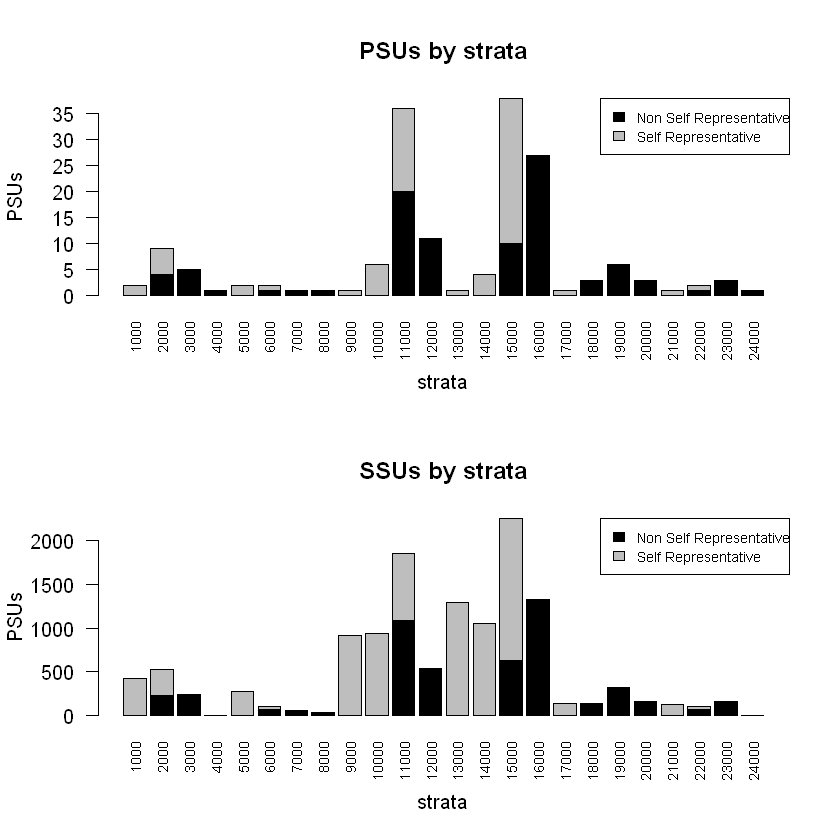

In [20]:
## Plot of allocation (PSUs and SSUs)
des <- sample_2st[[2]]
des2 <- NULL
des2$strata <- c(des$Domain[1:24],des$Domain[1:24])
des2$SR <- c(rep("SR",24),rep("nSR",24))
des2$PSU <- as.numeric(c(des$SRdom[1:24],des$nSRdom[1:24]))
des2$SSU <- as.numeric(c(des$SR_PSU_final_sample_unit[1:24],des$NSR_PSU_final_sample_unit[1:24]))
des2 <- as.data.frame(des2)
des2$strata <- as.numeric(des2$strata)
par(mfrow=c(2, 1))
barplot(PSU~SR+strata, data=des2,
        main = "PSUs by strata",
        xlab = "strata", ylab = "PSUs",
        col = c("black", "grey"),
        # beside = TRUE,
        las=2,
        cex.names=0.7)
legend("topright", 
       legend = c("Non Self Representative","Self Representative"),cex = 0.7,
       fill = c("black", "grey"))
barplot(SSU~SR+strata, data=des2,
        main = "SSUs by strata",
        xlab = "strata", ylab = "PSUs",
        col = c("black", "grey"),
        # beside = TRUE,
        las=2,
        cex.names=0.7)
legend("topright", 
       legend = c("Non Self Representative","Self Representative"),cex = 0.7,
       fill = c("black", "grey"))


## Selection of SSUs (II stage)

In [21]:
selected_PSU <- sample_2st[[4]]
selected_PSU <- selected_PSU[selected_PSU$PSU_final_sample_unit > 0,]
samp <- select_SSU(df=pop,
                   PSU_code="municipality",
                   SSU_code="id_ind",
                   PSU_sampled=selected_PSU[selected_PSU$Sampled_PSU==1,],
                   verbose=TRUE)



PSU =  1  *** Selected SSU =  48
PSU =  2  *** Selected SSU =  115
PSU =  3  *** Selected SSU =  58
PSU =  4  *** Selected SSU =  43
PSU =  5  *** Selected SSU =  911
PSU =  6  *** Selected SSU =  52
PSU =  7  *** Selected SSU =  167
PSU =  8  *** Selected SSU =  126
PSU =  9  *** Selected SSU =  63
PSU =  10  *** Selected SSU =  66
PSU =  11  *** Selected SSU =  44
PSU =  12  *** Selected SSU =  56
PSU =  13  *** Selected SSU =  55
PSU =  14  *** Selected SSU =  45
PSU =  15  *** Selected SSU =  42
PSU =  16  *** Selected SSU =  60
PSU =  17  *** Selected SSU =  55
PSU =  18  *** Selected SSU =  42
PSU =  19  *** Selected SSU =  53
PSU =  20  *** Selected SSU =  55
PSU =  21  *** Selected SSU =  42
PSU =  22  *** Selected SSU =  41
PSU =  23  *** Selected SSU =  43
PSU =  24  *** Selected SSU =  138
PSU =  25  *** Selected SSU =  93
PSU =  26  *** Selected SSU =  41
PSU =  27  *** Selected SSU =  49
PSU =  28  *** Selected SSU =  54
PSU =  29  *** Selected SSU =  297
PSU =  30  *** S

In [22]:
nrow(samp)
sum(allocat$ALLOC)

[1] 13015

[1] 13011

In [23]:
nrow(pop)
sum(samp$weight)

[1] 2258507

[1] 2258507

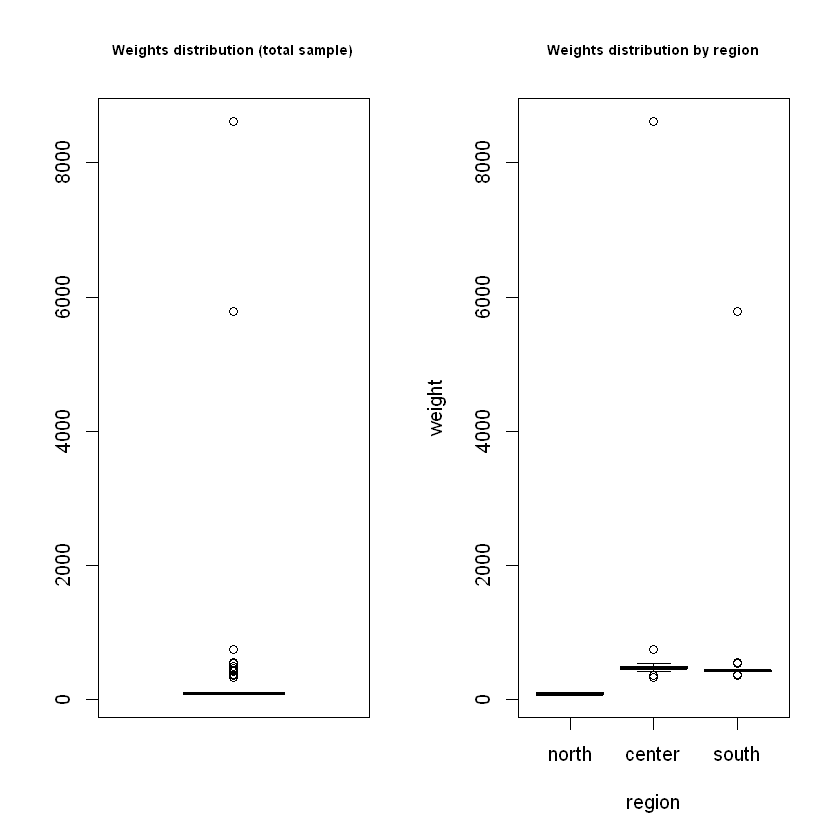

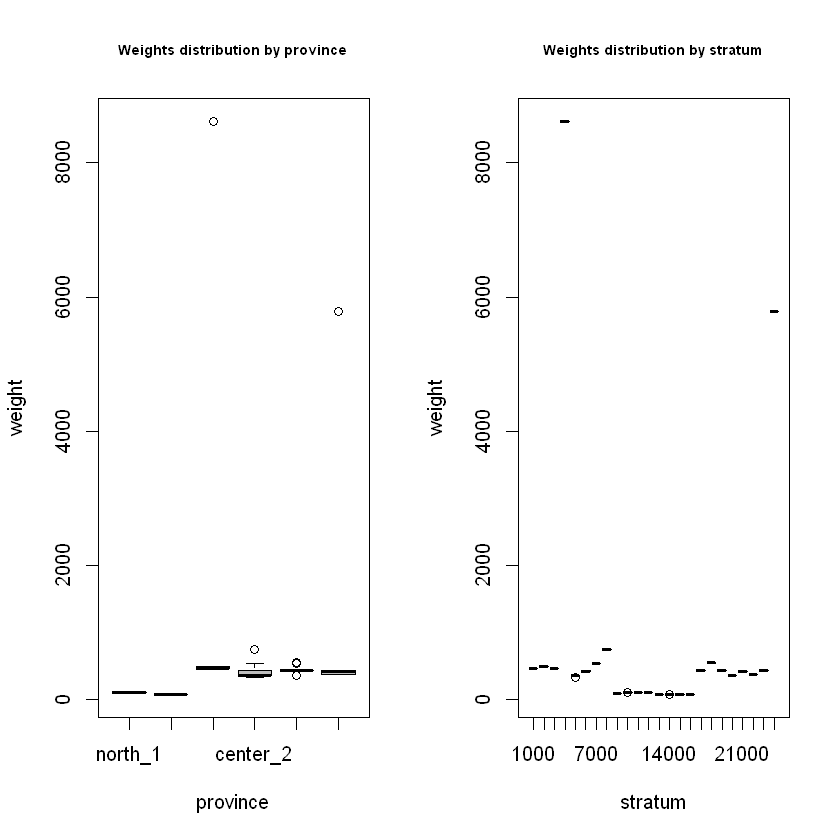

In [24]:
## Plot of weights distribution
par(mfrow=c(1, 2))
boxplot(samp$weight,col="grey")
title("Weights distribution (total sample)",cex.main=0.7)
boxplot(weight ~ region, data=samp,col="grey")
title("Weights distribution by region",cex.main=0.7)
par(mfrow=c(1, 2))
boxplot(weight ~ province, data=samp,col="grey")
title("Weights distribution by province",cex.main=0.7)
boxplot(weight ~ stratum, data=samp,col="grey")
title("Weights distribution by stratum",cex.main=0.7)

## Precision constraints compliance control (by simulation)

In [25]:
selected_PSU <- sample_2st[[4]]
df=pop
df$one <- 1
PSU_code="municipality"
SSU_code="id_ind"
PSU_sampled=selected_PSU[selected_PSU$Sampled_PSU==1,]
target_vars <- c("income_hh",
                 "active",
                 "inactive",
                 "unemployed")  
PSU_sampled <- selected_PSU[selected_PSU$PSU_final_sample_unit > 0,]

In [26]:
# Domain level = national
domain_var <- "one"
eval <- eval_2stage(df,
                    PSU_code,
                    SSU_code,
                    domain_var,
                    target_vars,
                    PSU_sampled,
                    nsampl=100, 
                    writeFiles=FALSE,
                    progress=TRUE) 
eval$coeff_var

  |======================================================================| 100%


CV1    CV2    CV3    CV4    dom 
1 0.0091 0.0094 0.0244 0.0378 DOM1

  |======================================================================| 100%


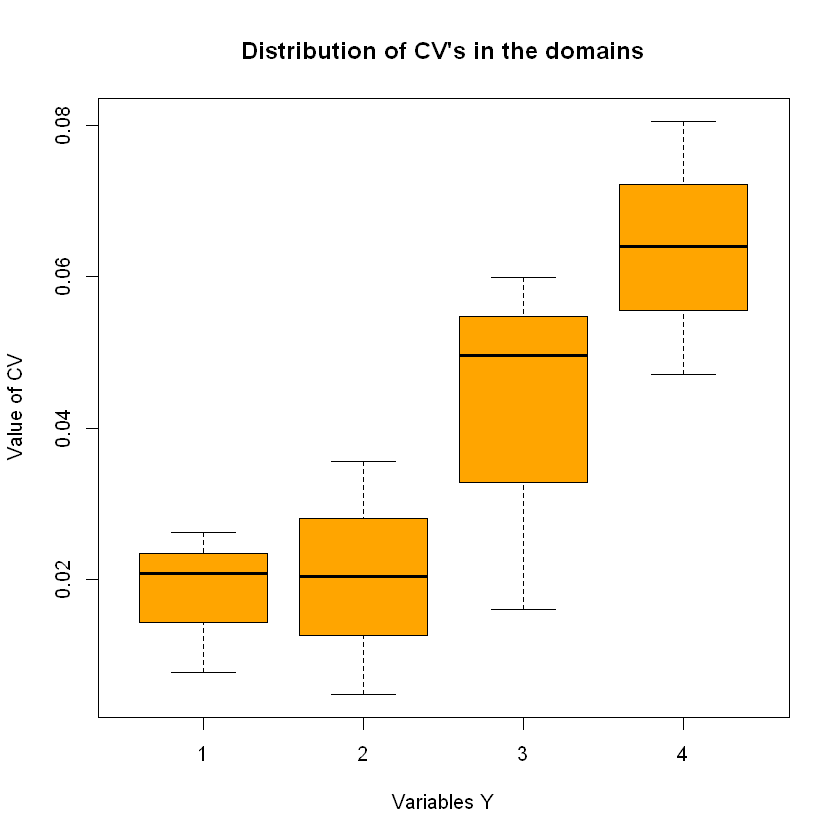

CV1    CV2    CV3    CV4    dom 
1 0.0078 0.0048 0.0160 0.0640 DOM1
2 0.0209 0.0205 0.0496 0.0805 DOM2
3 0.0262 0.0356 0.0599 0.0471 DOM3

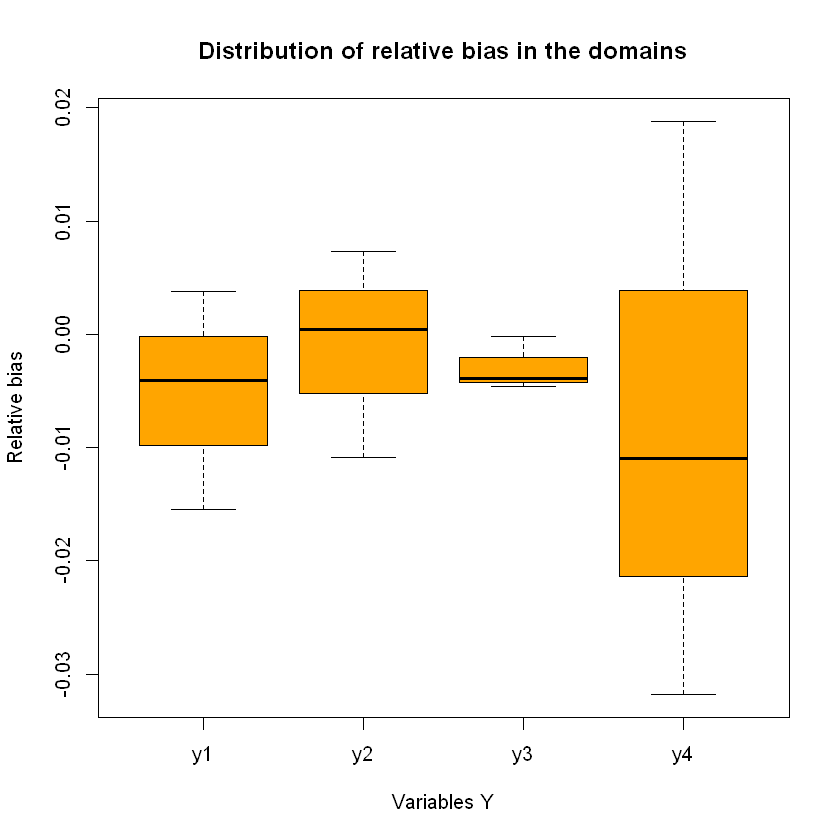

In [27]:
# Domain level = regional
domain_var <- "region"
set.seed(1234)
eval <- eval_2stage(df,
                    PSU_code,
                    SSU_code,
                    domain_var,
                    target_vars,
                    PSU_sampled,
                    nsampl=100, 
                    writeFiles=FALSE,
                    progress=TRUE) 
eval$coeff_var

  |======================================================================| 100%


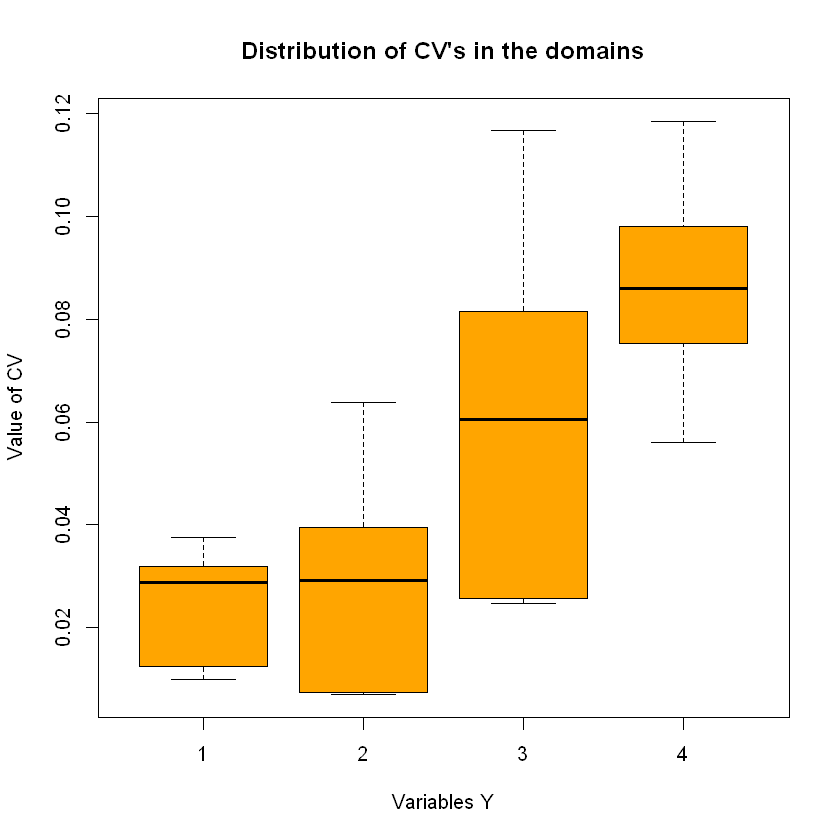

CV1    CV2    CV3    CV4    dom 
1 0.0125 0.0070 0.0257 0.0959 DOM1
2 0.0099 0.0073 0.0246 0.0762 DOM2
3 0.0259 0.0241 0.0596 0.0980 DOM3
4 0.0319 0.0343 0.0815 0.1185 DOM4
5 0.0317 0.0394 0.0612 0.0560 DOM5
6 0.0376 0.0637 0.1166 0.0753 DOM6

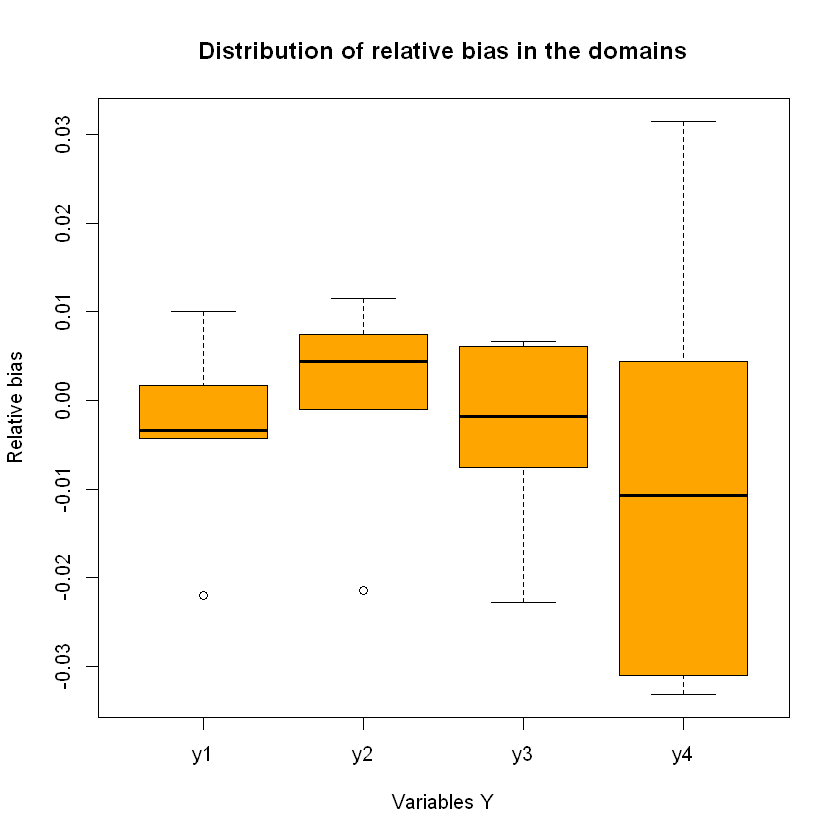

In [28]:
# Domain level = provincial
domain_var <- "province"
set.seed(1234)
eval <- eval_2stage(df,
                    PSU_code,
                    SSU_code,
                    domain_var,
                    target_vars,
                    PSU_sampled,
                    nsampl=100, 
                    writeFiles=FALSE,
                    progress=TRUE) 
eval$coeff_var

In [29]:
alloc$sensitivity

Type Dom V1 V2 V3 V4  
1  DOM1 1   1  1   1  442
5  DOM2 1   1  0   1 2022
9  DOM2 2   1  1  16  123
13 DOM2 3   1  1   1    1